In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import librosa.display
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Set the parent directory for speaker folders
#D:\OneDrive - TVS Motor Company Ltd\Documents\archive
parent_dir = "./archive2/16000_pcm_speeches/audio"
#parent_dir ="D:/OneDrive - TVS Motor Company Ltd/Documents/archive/16000_pcm_speeches/audio"
# List of speaker folders
speaker_folders = [
    "Abhishek",
    "Anirban",
    "Arunanshu",
    "Shivam",
    "Sunamdha"
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=48000, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=90)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [5]:
print(X.shape)
print(y.shape)

(7830, 94, 90)
(7830,)


In [6]:
d1, d2, d3= X.shape

print(d1)
print(d2)
print(d3)

7830
94
90


In [7]:
# Convert features and labels to a DataFrame
df = pd.DataFrame(X.reshape(X.shape[0], -1))  # Reshape features into 2D array
df['label'] = y  # Add labels as a new column

# Save DataFrame to CSV
df.to_csv('mfcc_features2.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('mfcc_features2.csv')

# Extract features (X) and labels (y)
X = df.drop('label', axis=1).values  # Drop the 'label' column to get features
y = df['label'].values

# Reshape the features back to their original shape
# Here, assuming each row represents one sample and the features were flattened into a single row
# If your features were saved differently, adjust the reshaping accordingly
num_samples = df.shape[0]  # Number of samples
num_features = df.shape[1] - 1  # Number of features (excluding the label column)
X = X.reshape(num_samples, -1, num_features)  # Reshape back to the original shape

# Display the shapes of X and y to verify
# print("Shape of X:", X.shape)
# print("Shape of y:", y.shape)

X = X.reshape(X.shape[0], d2, d3)
print(X.shape)

(7830, 94, 90)


In [8]:
# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_test.shape)

Training Data Shape: (5481, 94, 90)
Validation Data Shape: (2349, 94, 90)




Epoch 1/20


43/43 [==============================] - 36s 638ms/step - loss: 1.2939 - accuracy: 0.6054 - val_loss: 0.5361 - val_accuracy: 0.9493
Epoch 2/20
43/43 [==============================] - 28s 651ms/step - loss: 0.3661 - accuracy: 0.9513 - val_loss: 0.3870 - val_accuracy: 0.9493
Epoch 3/20
43/43 [==============================] - 27s 621ms/step - loss: 0.2860 - accuracy: 0.9683 - val_loss: 0.3274 - val_accuracy: 0.9770
Epoch 4/20
43/43 [==============================] - 26s 598ms/step - loss: 0.2257 - accuracy: 0.9818 - val_loss: 0.3073 - val_accuracy: 0.9583
Epoch 5/20
43/43 [==============================] - 27s 626ms/step - loss: 0.2353 - accuracy: 0.9710 - val_loss: 0.2202 - val_accuracy: 0.9762
Epoch 6/20
43/43 [==============================] - 27s 642ms/step - loss: 0.1665 - accuracy: 0.9900 - val_loss: 0.1758 - val_accuracy: 0.9868
Epoch 7/20
43/43 [==============================] - 28s 657ms/step - loss: 0.1661 - accuracy: 0.9887 - val_loss: 0.1427 - val_accuracy: 0.

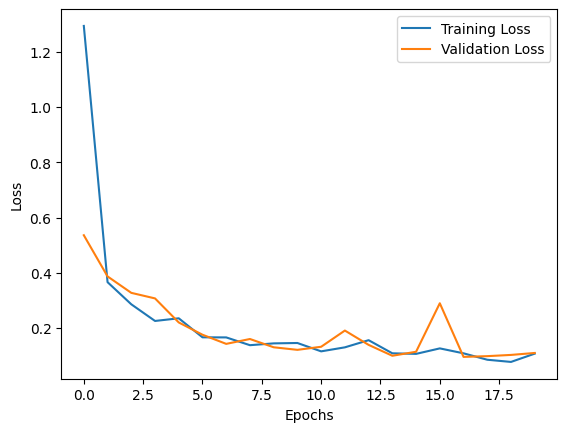

In [9]:
from tensorflow.keras.regularizers import l2
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
    tf.keras.layers.LSTM(128),
    #tf.keras.layers.LSTM(128),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=21, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

74/74 [==============================] - 7s 71ms/step
Test Evaluation Accuracy: 0.9868028948488718
Weighted F1 Score: 0.9868549873989816


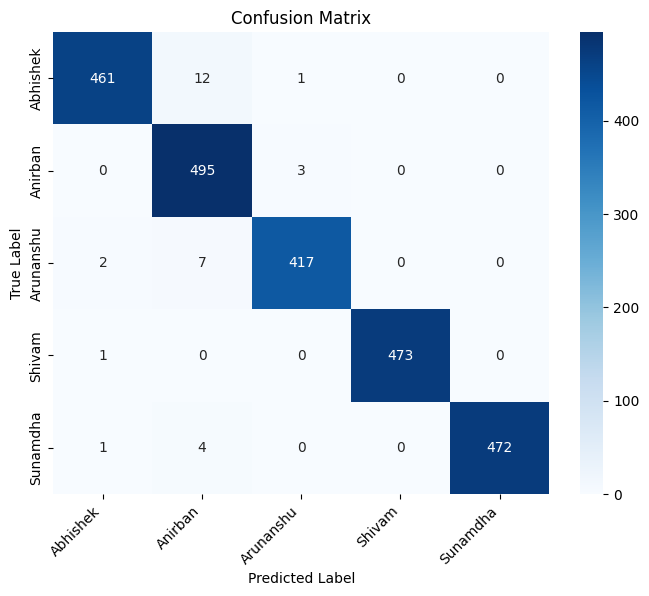

In [10]:
# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Testing**

In [11]:
# Set the parent directory for speaker folders
parent_dir = "./archive2/Article/16000_pcm_speeches/audio"

# List of speaker folders
speaker_folders = [
    "Abhishek",
    "Anirban",
    "Arunanshu",
    "Shivam",
    "Sunamdha"
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=48000, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=90)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X_test, y_test = extract_features(parent_dir, speaker_folders)

In [12]:
print(X_test.shape)
print(y_test.shape)

(1593, 94, 90)
(1593,)


In [13]:
# Convert features and labels to a DataFrame
df2 = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))  # Reshape features into 2D array
df2['label'] = y_test  # Add labels as a new column

# Save DataFrame to CSV
df2.to_csv('mfcc_test_features2.csv', index=False)


# Read the CSV file into a DataFrame
df2 = pd.read_csv('mfcc_test_features2.csv')

# Extract features (X) and labels (y)
X_test = df2.drop('label', axis=1).values  # Drop the 'label' column to get features
y_test = df2['label'].values

# Reshape the features back to their original shape
# Here, assuming each row represents one sample and the features were flattened into a single row
# If your features were saved differently, adjust the reshaping accordingly
num_samples = df2.shape[0]  # Number of samples
num_features = df2.shape[1] - 1  # Number of features (excluding the label column)
X_test = X_test.reshape(num_samples, -1, num_features)  # Reshape back to the original shape

# Display the shapes of X and y to verify
# print("Shape of X:", X_test.shape)
# print("Shape of y:", y_test.shape)

X_test = X_test.reshape(X_test.shape[0], d2, d3)
print(X_test.shape)


(1593, 94, 90)


50/50 [==============================] - 4s 70ms/step
Test Evaluation Accuracy: 0.8706842435655995
Weighted F1 Score: 0.8692237579239724


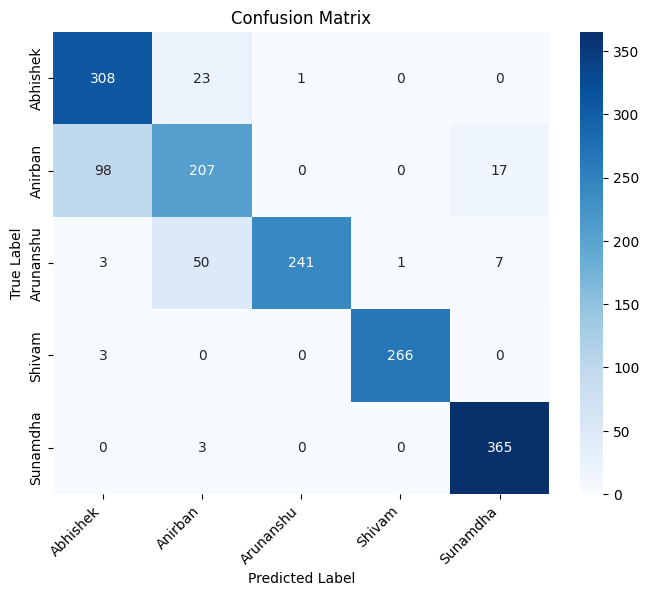

In [14]:
# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

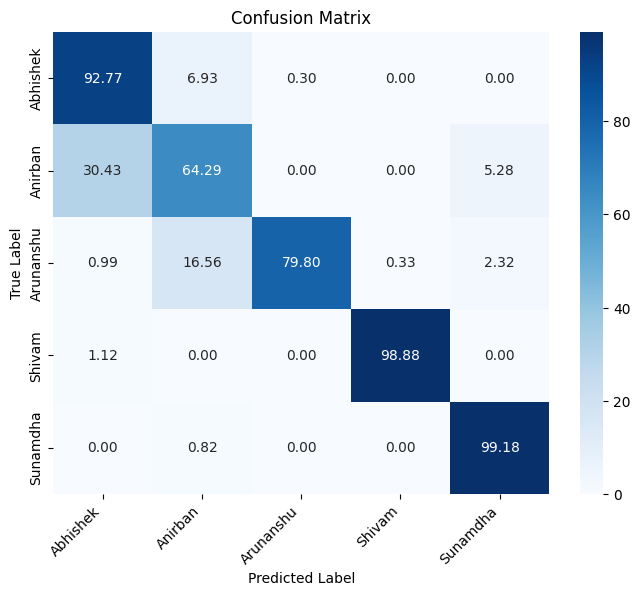

In [15]:
# Convert confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [16]:
import joblib
model_save_filename="Five_speaker_model_4rd_best.joblib"
joblib.dump(model, model_save_filename)

['Five_speaker_model_4rd_best.joblib']